In [1]:
import os
cwd = os.getcwd()
%cd ../
# add path to sys
import sys
# SRC_DIR = os.path.dirname(os.path.abspath('src'))
# sys.path.append(SRC_DIR)
sys.argv = ['']

# import modules
import torch
import csv
import src.util as util
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering
from transformers import DistilBertModel, DistilBertConfig

from src.args import get_args
from src.model import QAGAN, QAGANConfig
from src.trainer import Trainer

/dominus/workspace/StanfordGraduateCourses/CS224N/QAGAN


In [2]:
# define parser and arguments
args = get_args()
args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
args.batch_size = 1

util.set_seed(args.seed)

# override certain configs
args.variant = 'qagan-v0-conditional'
exp_id = 'init-nll-lowtemp-finetune-01'
args.eval_datasets = 'race,relation_extraction,duorc'
args.eval_dir = 'datasets/oodomain_test'
args.pretrained_model = os.path.join('save', '{}.{}'.format(args.variant, exp_id), 'checkpoint')
args.recompute_features = False

# load pre-trained base model
model, tokenizer = None, None
if args.variant == 'baseline-v0':
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
else:
    config = DistilBertConfig()
    config.output_hidden_states = False
    config.output_attentions = False
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    backbone = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
    if args.variant == 'baseline-v1':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer)
    elif args.variant == 'baseline-v1-conditional':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer,
                              prediction_head='conditional_linear')
    elif args.variant == 'baseline-v1-conditional-att':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer,
                              prediction_head='conditional_attention')
    elif args.variant == 'qagan-v0':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer, 
                              use_discriminator=True,
                              discriminate_cls=True)
    elif args.variant == 'qagan-v1':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer, 
                              use_discriminator=True,
                              discriminate_cls_sep=True)
    elif args.variant == 'qagan-v2':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer, 
                              use_discriminator=True,
                              discriminate_hidden_layers=True)
    elif args.variant == 'qagan-v0-conditional-att':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer, 
                              use_discriminator=True,
                              discriminate_cls=True,
                              prediction_head='conditional_attention')
    elif args.variant == 'qagan-v0-conditional':
        qconfig = QAGANConfig(backbone=backbone, 
                              tokenizer=tokenizer, 
                              use_discriminator=True,
                              discriminate_cls=True,
                              prediction_head='conditional_linear')
    else:
        raise ValueError

# mode of operation
split_name = 'test'
logger = util.get_logger(args.save_dir, f'log_{split_name}')

# load pretrained model
checkpoint_path = os.path.join(args.save_dir, 'checkpoint')
if args.variant == 'baseline-v0':
    model = DistilBertForQuestionAnswering.from_pretrained(checkpoint_path)
else:
    model = QAGAN(config=qconfig).from_pretrained(args.pretrained_model)

loaded pretrained model from save/qagan-v0-conditional.init-nll-lowtemp-finetune-01/checkpoint


In [3]:
# utils
def prepare_eval_data(dataset_dict, tokenizer):
    tokenized_examples = tokenizer(dataset_dict['question'],
                                   dataset_dict['context'],
                                   truncation="only_second",
                                   stride=128,
                                   max_length=384,
                                   return_overflowing_tokens=True,
                                   return_offsets_mapping=True,
                                   padding='max_length')
    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # For evaluation, we will need to convert our predictions to substrings of the context, so we keep the
    # corresponding example_id and we will store the offset mappings.
    tokenized_examples["id"] = []
    tokenized_examples["labels"] = []
    for i in tqdm(range(len(tokenized_examples["input_ids"]))):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["id"].append(dataset_dict["id"][sample_index])
        # label corresponding to the dataset class
        tokenized_examples["labels"].append(dataset_dict['labels'][sample_index])
        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == 1 else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

def read_and_process(args, tokenizer, dataset_dict, dir_name, dataset_name):
    cache_path = f'{dir_name}/{dataset_name}_encodings.pt'
    if os.path.exists(cache_path) and not args.recompute_features:
        tokenized_examples = util.load_pickle(cache_path)
    else:
        tokenized_examples = prepare_eval_data(dataset_dict, tokenizer)
        util.save_pickle(tokenized_examples, cache_path)
    return tokenized_examples

def get_dataset(args, datasets, data_dir, tokenizer, split_name):
    datasets = datasets.split(',')
    dataset_dict = None
    dataset_name=''
    for i, dataset in enumerate(datasets):
        dataset_name += f'_{dataset}'
        dataset_dict_curr = util.read_squad(f'{data_dir}/{dataset}')
        dataset_dict = util.merge(dataset_dict, dataset_dict_curr, i)
    data_encodings = read_and_process(args, tokenizer, dataset_dict, data_dir, dataset_name)
    return util.QADataset(data_encodings, train=(split_name=='train')), dataset_dict

In [4]:
import json
from lib2to3.pgen2.tokenize import tokenize
import os
from collections import OrderedDict
import torch
import csv
import numpy as np
from tqdm.autonotebook import tqdm 
from src import util
from tensorboardX import SummaryWriter
from torch.utils.data.sampler import RandomSampler, SequentialSampler


from torch.utils.data import DataLoader

# perform forward pass over test dataloader
split_name = 'test' if 'test' in args.eval_dir else 'validation'
model.to(args.device)
eval_dataset,eval_dict = \
    get_dataset(args, args.eval_datasets, args.eval_dir, tokenizer, split_name)

eval_dataloader = DataLoader(eval_dataset,
                             batch_size=args.batch_size,
                             sampler=SequentialSampler(eval_dataset))

# forward pass
dataset_classes = []
sequence_hidden_states = []
with torch.no_grad(), \
        tqdm(total=len(eval_dataloader.dataset)) as progress_bar:
    for batch in eval_dataloader:
        # Setup for forward
        input_ids = batch['input_ids'].to(args.device)
        attention_mask = batch['attention_mask'].to(args.device)
        dataset_class = batch['labels'].to(args.device)
        batch_size = len(input_ids)
        # model inputs
        model_input_dict = {'input_ids': input_ids,
                            'attention_mask': attention_mask,
                            'return_hidden_states': True}

        outputs = model(**model_input_dict)
        
        # append to list
        dataset_classes.append(dataset_class[0].cpu().numpy())
        sequence_hidden_states.append(outputs.hidden_states[0,0].cpu().numpy()) # only [CLS]
        
        progress_bar.update(args.batch_size)
        
# convert to numpy and pick few samples randomly:]
dataset_classes = np.array(dataset_classes)
sequence_hidden_states = np.array(sequence_hidden_states)
# randomly shuffle indices
max_n_samples = 5000
indices = np.random.permutation(sequence_hidden_states.shape[0])[:max_n_samples]
dataset_classes = dataset_classes[indices]
sequence_hidden_states = sequence_hidden_states[indices]

In [5]:
print(dataset_classes.shape)
print(sequence_hidden_states.shape)

(5000,)
(5000, 768)


In [6]:
def register_color_codes(dataset_ids):
    """ Register colorcodes randomly generated for each
    vehicle keypoints.
    """
    colorcodes = {}
    for id in dataset_ids:
        rgb = np.random.randint(0, 255, 3, dtype=np.uint8)
        colorcodes[id] = rgb.tolist()

    return colorcodes

In [7]:
from sklearn.manifold import TSNE

# TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result_2d = tsne.fit_transform(sequence_hidden_states)

# TSNE embedding with 3 dimensions
n_components = 3
tsne = TSNE(n_components)
tsne_result_3d = tsne.fit_transform(np.array(sequence_hidden_states))

# register unique colors for each id
colorcodes = register_color_codes(dataset_classes)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


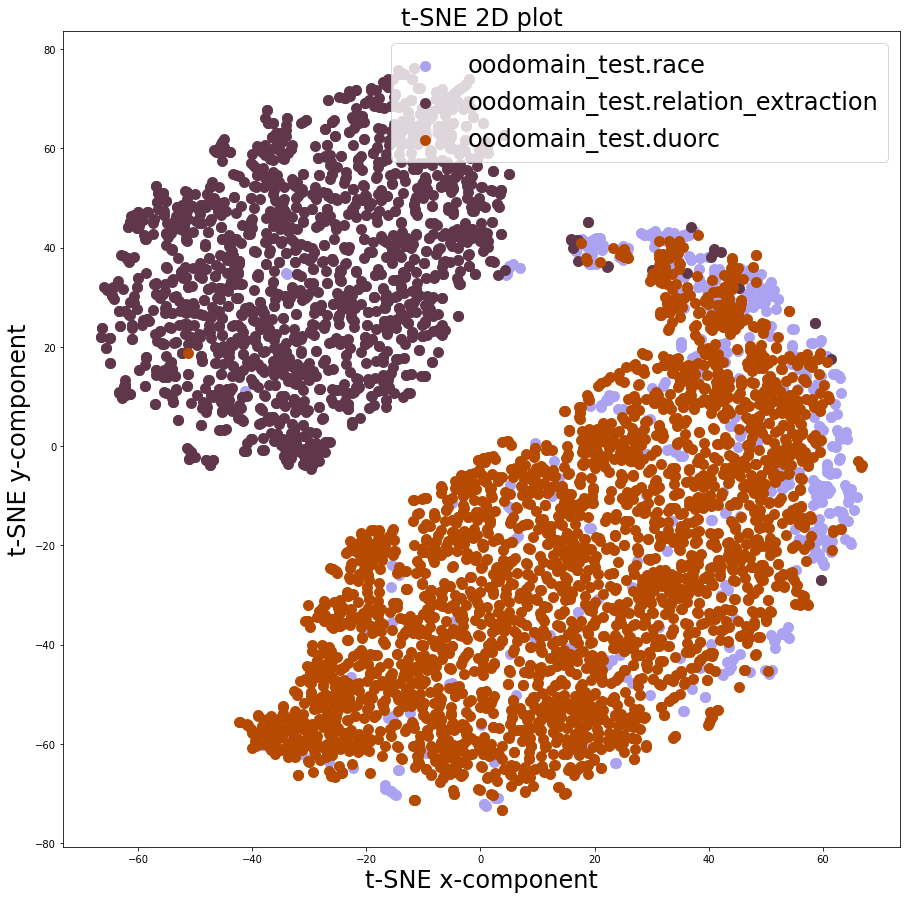

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


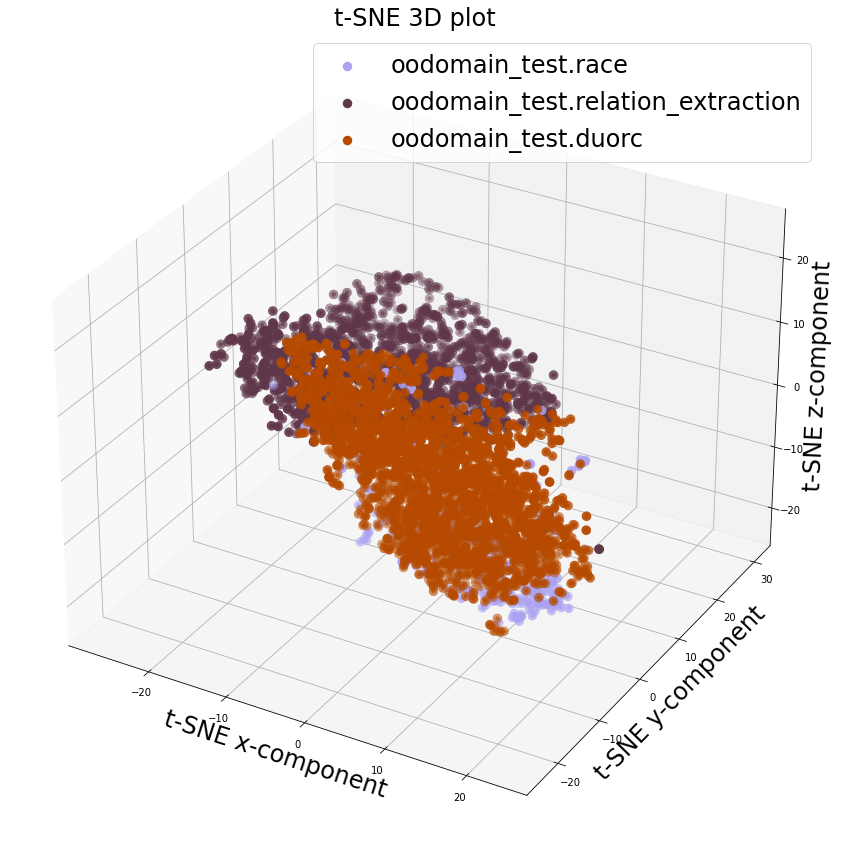

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# plots directory
plots_dir = os.path.join('{}/plots'.format(cwd), '{}.{}'.format(args.variant, exp_id))
if not os.path.exists(plots_dir):
    os.system('mkdir -p {}'.format(plots_dir))
plot_2d_png = os.path.join(plots_dir, 'tsne_2d.png')
plot_3d_png = os.path.join(plots_dir, 'tsne_3d.png')

# dataset name
domain = args.eval_dir.split('/')[-1]
dataset_names = [domain+'.'+dataset_str for dataset_str in args.eval_datasets.split(',')]
# t-SNE plot
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_xlabel('t-SNE x-component', fontsize=24)
ax.set_ylabel('t-SNE y-component', fontsize=24)
ax.set_title('t-SNE 2D plot'.format(split_name), fontsize=24)
# 3d plot
for id in np.unique(dataset_classes):
    dataset_id_indices = np.where(dataset_classes==id)
    ax.scatter( tsne_result_2d[dataset_id_indices,0], 
                tsne_result_2d[dataset_id_indices,1], 
                linewidth=5.0, 
                c=np.array(colorcodes[id])/255.0, 
                label='{}'.format( dataset_names[id]))
ax.legend(prop={'size': 24})
plt.savefig(plot_2d_png)
plt.show()

# t-SNE plot
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.set_xlabel('t-SNE x-component', fontsize=24)
ax.set_ylabel('t-SNE y-component', fontsize=24)
ax.set_zlabel('t-SNE z-component', fontsize=24)
ax.set_title('t-SNE 3D plot'.format(split_name), fontsize=24)
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)
# ax.set_zlim(-10, 10)
# 3d plot
for id in np.unique(dataset_classes):
    dataset_id_indices = np.where(dataset_classes==id)
    ax.scatter( tsne_result_3d[dataset_id_indices,0], 
                tsne_result_3d[dataset_id_indices,1], 
                tsne_result_3d[dataset_id_indices,2], 
                linewidth=5.0, 
                c=np.array(colorcodes[id])/255.0, 
                label='{}'.format(dataset_names[id]))
ax.legend(prop={'size': 24})
plt.savefig(plot_3d_png)
plt.show()
plt.close()

## Do this for all datasets

In [9]:
args.eval_datasets = 'squad,nat_questions,newsqa'
args.eval_dir = 'datasets/indomain_val'

dataset_classes = []
sequence_hidden_states = []

# perform forward pass over dataloader
split_name = 'test' if 'test' in args.eval_dir else 'validation'
model.to(args.device)
eval_dataset,eval_dict = \
    get_dataset(args, args.eval_datasets, args.eval_dir, tokenizer, split_name)

eval_dataloader = DataLoader(eval_dataset,
                             batch_size=args.batch_size,
                             sampler=SequentialSampler(eval_dataset))

# dataset name
domain = args.eval_dir.split('/')[-1]
dataset_names = [domain+'.'+dataset_str for dataset_str in args.eval_datasets.split(',')]

# forward pass
with torch.no_grad(), \
        tqdm(total=len(eval_dataloader.dataset), desc='indomain') as progress_bar:
    for batch in eval_dataloader:
        # Setup for forward
        input_ids = batch['input_ids'].to(args.device)
        attention_mask = batch['attention_mask'].to(args.device)
        dataset_class = batch['labels'].to(args.device)
        batch_size = len(input_ids)
        # model inputs
        model_input_dict = {'input_ids': input_ids,
                            'attention_mask': attention_mask,
                            'return_hidden_states': True}

        outputs = model(**model_input_dict)
        
        # append to list
        dataset_classes.append(dataset_class[0].cpu().numpy())
        sequence_hidden_states.append(outputs.hidden_states[0,0].cpu().numpy()) # only [CLS]
        
        progress_bar.update(args.batch_size)
len_indomain_dataset = len(np.unique(dataset_classes))

args.eval_datasets = 'race,relation_extraction,duorc'
args.eval_dir = 'datasets/oodomain_test'

# perform forward pass over dataloader
split_name = 'test' if 'test' in args.eval_dir else 'validation'
model.to(args.device)
eval_dataset,eval_dict = \
    get_dataset(args, args.eval_datasets, args.eval_dir, tokenizer, split_name)

eval_dataloader = DataLoader(eval_dataset,
                             batch_size=args.batch_size,
                             sampler=SequentialSampler(eval_dataset))

# dataset name
domain = args.eval_dir.split('/')[-1]
dataset_names += [domain+'.'+dataset_str for dataset_str in args.eval_datasets.split(',')]

# forward pass
with torch.no_grad(), \
        tqdm(total=len(eval_dataloader.dataset), desc='oodomain') as progress_bar:
    for batch in eval_dataloader:
        # Setup for forward
        input_ids = batch['input_ids'].to(args.device)
        attention_mask = batch['attention_mask'].to(args.device)
        dataset_class = batch['labels'].to(args.device)
        batch_size = len(input_ids)
        # model inputs
        model_input_dict = {'input_ids': input_ids,
                            'attention_mask': attention_mask,
                            'return_hidden_states': True}

        outputs = model(**model_input_dict)
        
        # append to list
        dataset_classes.append(len_indomain_dataset+dataset_class[0].cpu().numpy())
        sequence_hidden_states.append(outputs.hidden_states[0,0].cpu().numpy()) # only [CLS]
        
        progress_bar.update(args.batch_size)

# convert to numpy and pick few samples randomly:]
dataset_classes = np.array(dataset_classes)
sequence_hidden_states = np.array(sequence_hidden_states)
# randomly shuffle indices
max_n_samples = 5000
indices = np.random.permutation(sequence_hidden_states.shape[0])[:max_n_samples]
dataset_classes = dataset_classes[indices]
sequence_hidden_states = sequence_hidden_states[indices]

In [10]:
print(dataset_classes.shape)
print(sequence_hidden_states.shape)

(5000,)
(5000, 768)


In [11]:
# TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result_2d = tsne.fit_transform(sequence_hidden_states)

# TSNE embedding with 3 dimensions
n_components = 3
tsne = TSNE(n_components)
tsne_result_3d = tsne.fit_transform(np.array(sequence_hidden_states))

# register unique colors for each id
colorcodes = register_color_codes(dataset_classes)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

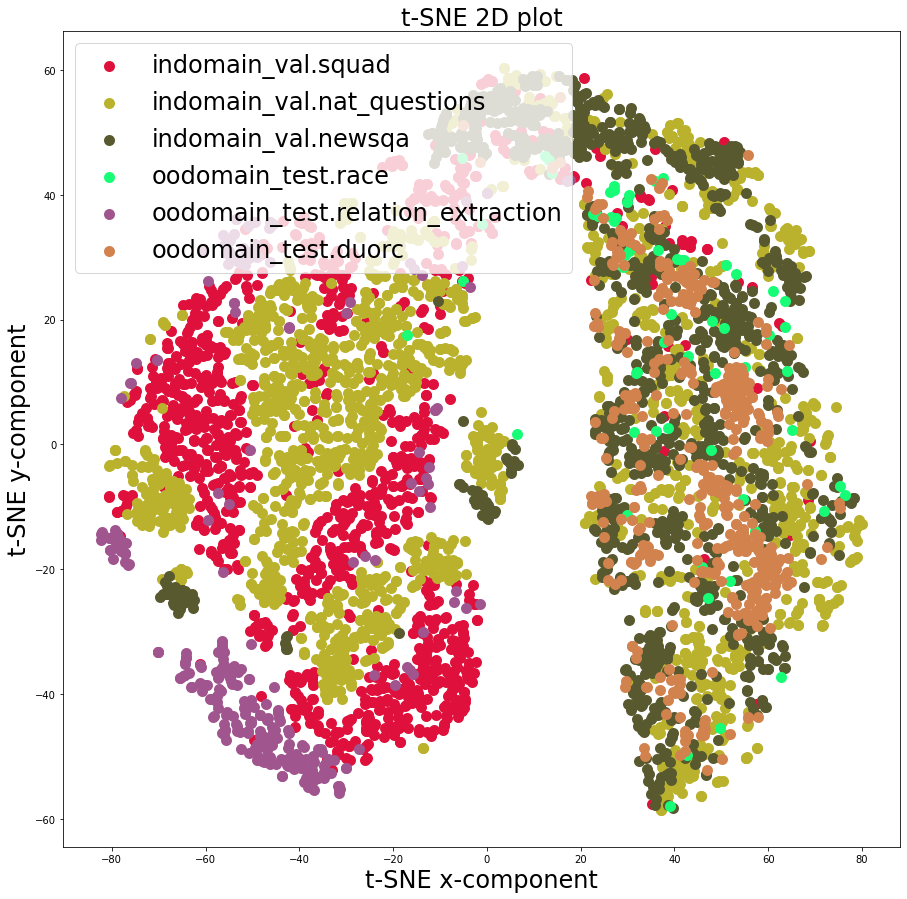

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

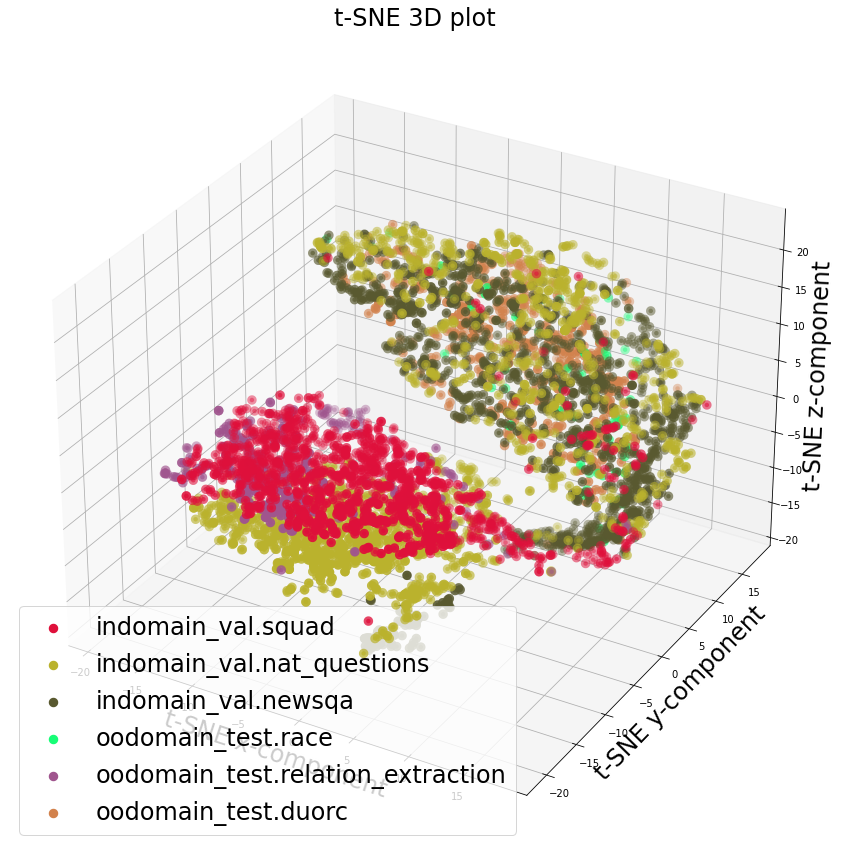

In [12]:
# plots filename
plot_2d_png = os.path.join(plots_dir, 'tsne_2d_all.png')
plot_3d_png = os.path.join(plots_dir, 'tsne_3d_all.png')

# t-SNE plot
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_xlabel('t-SNE x-component', fontsize=24)
ax.set_ylabel('t-SNE y-component', fontsize=24)
ax.set_title('t-SNE 2D plot'.format(split_name), fontsize=24)
# 3d plot
for id in np.unique(dataset_classes):
    dataset_id_indices = np.where(dataset_classes==id)
    ax.scatter( tsne_result_2d[dataset_id_indices,0], 
                tsne_result_2d[dataset_id_indices,1], 
                linewidth=5.0, 
                c=np.array(colorcodes[id])/255.0, 
                label='{}'.format(dataset_names[id]))
ax.legend(prop={'size': 24})
plt.savefig(plot_2d_png)
plt.show()

# t-SNE plot
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.set_xlabel('t-SNE x-component', fontsize=24)
ax.set_ylabel('t-SNE y-component', fontsize=24)
ax.set_zlabel('t-SNE z-component', fontsize=24)
ax.set_title('t-SNE 3D plot'.format(split_name), fontsize=24)
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)
# ax.set_zlim(-10, 10)
# 3d plot
for id in np.unique(dataset_classes):
    dataset_id_indices = np.where(dataset_classes==id)
    ax.scatter( tsne_result_3d[dataset_id_indices,0], 
                tsne_result_3d[dataset_id_indices,1], 
                tsne_result_3d[dataset_id_indices,2], 
                linewidth=5.0, 
                c=np.array(colorcodes[id])/255.0, 
                label='{}'.format(dataset_names[id]))
ax.legend(prop={'size': 24})
plt.savefig(plot_3d_png)
plt.show()
plt.close()